In [1]:
from keras.models import Model
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,ZeroPadding2D
from keras.layers import add,Flatten
#from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D
from keras.optimizers import SGD
import numpy as np
seed = 10
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10

In [3]:
(x_train_image,y_train_label),(x_test_image,y_test_label) = cifar10.load_data()
x_Train_normalize=x_train_image/255
x_Test_normalize=x_test_image/255
from keras.utils import np_utils
y_TrainOneHot=np_utils.to_categorical(y_train_label)
y_TestOneHot=np_utils.to_categorical(y_test_label)

In [4]:
def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
 
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x
 
def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)
        x = add([x,shortcut])
        return x
    else:
        x = add([x,inpt])
        return x

In [10]:
inpt = Input(shape=(32,32,3))
x = ZeroPadding2D((3,3))(inpt)
x = Conv2d_BN(x,nb_filter=64,kernel_size=(3,3),strides=(2,2),padding='valid')
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
 
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
 
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
 
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))

x = AveragePooling2D(pool_size=(3,3))(x)
x = Flatten()(x)
x = Dense(10,activation='softmax')(x)
 
model = Model(inputs=inpt,outputs=x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 18, 18, 64)   1792        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 18, 18, 64)   256         conv2d_140[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [11]:
train_history=model.fit(x=x_Train_normalize,y=y_TrainOneHot,validation_split=0.2,epochs=10,batch_size=128,verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 69s 2ms/step - loss: 1.6393 - acc: 0.4633 - val_loss: 1.3444 - val_acc: 0.5301
Epoch 2/10
40000/40000 [==============================] - 54s 1ms/step - loss: 1.0814 - acc: 0.6136 - val_loss: 1.2926 - val_acc: 0.5607
Epoch 3/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.8919 - acc: 0.6853 - val_loss: 1.1255 - val_acc: 0.6061
Epoch 4/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.7428 - acc: 0.7378 - val_loss: 1.3401 - val_acc: 0.5674
Epoch 5/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.6269 - acc: 0.7779 - val_loss: 1.0587 - val_acc: 0.6467
Epoch 6/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.5224 - acc: 0.8179 - val_loss: 1.0933 - val_acc: 0.6567
Epoch 7/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.4365 - acc: 0.8450 - val_loss: 1.1022 - val_acc

In [5]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

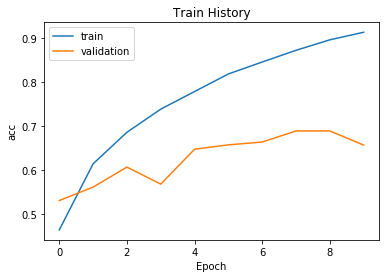

In [13]:
show_train_history(train_history,'acc','val_acc')

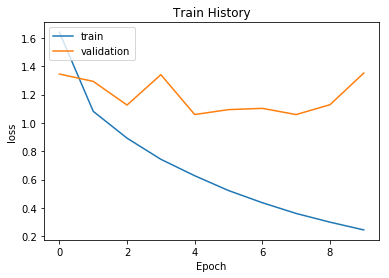

In [14]:
show_train_history(train_history,'loss','val_loss')

In [15]:
scores=model.evaluate(x_Test_normalize,y_TestOneHot)
print()
print('accuracy=',scores[1])

10000/10000 [==============================] - 6s 610us/step

accuracy= 0.6591


In [6]:
inpt = Input(shape=(32,32,3))
x = ZeroPadding2D((3,3))(inpt)
x = Conv2d_BN(x,nb_filter=64,kernel_size=(3,3),strides=(1,1),padding='SAME')
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
 
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
 
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
 
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))

x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3))

x = AveragePooling2D(pool_size=(7,7))(x)
x = Flatten()(x)
x = Dense(10,activation='softmax')(x)
 
model = Model(inputs=inpt,outputs=x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 38, 38, 64)   1792        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 38, 38, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [8]:
train_history=model.fit(x=x_Train_normalize,y=y_TrainOneHot,validation_split=0.2,epochs=10,batch_size=32,verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 1169s 29ms/step - loss: 1.7248 - acc: 0.4709 - val_loss: 3.1443 - val_acc: 0.3432
Epoch 2/10
40000/40000 [==============================] - 1165s 29ms/step - loss: 1.0504 - acc: 0.6294 - val_loss: 1.5135 - val_acc: 0.4955
Epoch 3/10
40000/40000 [==============================] - 1157s 29ms/step - loss: 0.8679 - acc: 0.6967 - val_loss: 1.2368 - val_acc: 0.6077
Epoch 4/10
40000/40000 [==============================] - 1172s 29ms/step - loss: 0.7488 - acc: 0.7407 - val_loss: 0.8991 - val_acc: 0.6899
Epoch 5/10
40000/40000 [==============================] - 1168s 29ms/step - loss: 0.6520 - acc: 0.7737 - val_loss: 0.8858 - val_acc: 0.6960
Epoch 6/10
40000/40000 [==============================] - 1161s 29ms/step - loss: 0.5885 - acc: 0.7966 - val_loss: 0.6800 - val_acc: 0.7678
Epoch 7/10
40000/40000 [==============================] - 1154s 29ms/step - loss: 0.4983 - acc: 0.8258 - val_l

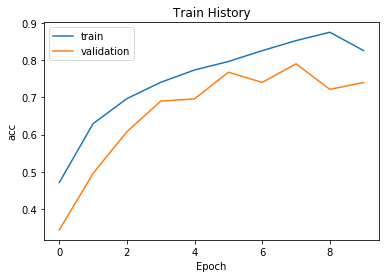

In [9]:
show_train_history(train_history,'acc','val_acc')

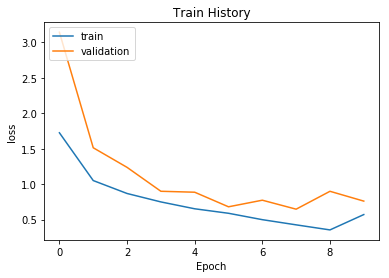

In [10]:
show_train_history(train_history,'loss','val_loss')

In [11]:
model.save_weights("SaveModel/cifarResModel.h5")
print("Save OK！")

Save OK！


In [12]:
scores=model.evaluate(x_Test_normalize,y_TestOneHot)
print()
print('accuracy=',scores[1])

10000/10000 [==============================] - 86s 9ms/step

accuracy= 0.7345
